<a href="https://colab.research.google.com/github/WooDeeB/github-slideshow/blob/master/TinyML_1_prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup environment
!pip install tensorflow tensorflow_datasets pydub numpy

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import pathlib
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

In [ ]:
# Define the path to save the dataset
dataset_dir = '/content/drive/My Drive/speech_commands_dataset'
os.makedirs(dataset_dir, exist_ok=True)

# Download and prepare the Google Speech Commands Dataset v1
def download_and_prepare_dataset(save_dir):
    dataset, info = tfds.load('speech_commands', data_dir=save_dir, with_info=True, as_supervised=True, download=True)
    print("Original dataset sizes:")
    print(f"Train: {info.splits['train'].num_examples}")
    print(f"Validation: {info.splits['validation'].num_examples}")
    print(f"Test: {info.splits['test'].num_examples}")
    return dataset, info

# Save the dataset to Google Drive
dataset, info = download_and_prepare_dataset(dataset_dir)

In [ ]:
# Check for the unique labels present within the first 1000 examples of the dataset
def check_unique_labels(dataset):
    labels = set()
    for _, label in dataset.take(1000):  # Check first 1000 examples
        labels.add(label.numpy())
    print("Unique labels:", labels)

# Print the labels
check_unique_labels(dataset['train'])
print("Label names:", info.features['label'].names)
for i, name in enumerate(info.features['label'].names):
    print(f"{i}: {name}")

In [ ]:
def prepare_datasets(dataset, info):
    """
    Prepare the datasets for training or evaluation by filtering them to include only specific commands
    and then applying preprocessing.
    """
    commands = ['yes', 'no'] # A list of the commands we want to keep in the dataset
    command_indices = tf.constant([info.features['label'].str2int(cmd) for cmd in commands], dtype=tf.int64) # Create a TensorFlow constant tensor holding these indices

    def filter_commands(audio, label):
        """
        Filterd the dataset, keeping only examples with labels matching the selected commands.
        """
        is_match = tf.reduce_any(tf.equal(label, command_indices))
        return tf.cast(is_match, tf.bool)  # Cast to a scalar boolean

    def preprocess_and_convert_label(audio, label):
        # First, apply the preprocessing
        audio = tf.pad(audio, [[0, 16000 - tf.shape(audio)[0]]])
        audio = audio[:16000]
        audio = tf.cast(audio, tf.float32) / 32768.0

        # Then, convert the label
        label = tf.where(tf.equal(label, info.features['label'].str2int('yes')), 1, 0)

        return audio, label

    def count_examples(dataset):
        return sum(1 for _ in dataset)

    print("Dataset sizes before filtering:")
    print(f"Train: {count_examples(dataset['train'])}")
    print(f"Validation: {count_examples(dataset['validation'])}")
    print(f"Test: {count_examples(dataset['test'])}")

    # Apply the filter to the dataset
    train_dataset = dataset['train'].filter(filter_commands)
    validation_dataset = dataset['validation'].filter(filter_commands)
    test_dataset = dataset['test'].filter(filter_commands)

    print("Dataset sizes after filtering:")
    print(f"Train: {count_examples(train_dataset)}")
    print(f"Validation: {count_examples(validation_dataset)}")
    print(f"Test: {count_examples(test_dataset)}")

    # Apply the preprocessing to the dataset
    train_dataset = train_dataset.map(preprocess_and_convert_label, num_parallel_calls=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.map(preprocess_and_convert_label, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(preprocess_and_convert_label, num_parallel_calls=tf.data.AUTOTUNE)

    # Optimise the performance of the datasets by batching, shuffling, caching, and prefetching data
    BATCH_SIZE = 64
    train_dataset = train_dataset.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_dataset, validation_dataset, test_dataset

# Prepare datasets
train_dataset, validation_dataset, test_dataset = prepare_datasets(dataset, info)

for audio, label in train_dataset.take(1):
    print(f"Audio shape: {audio.shape}")
    print(f"Label shape: {label.shape}")


Dataset sizes before filtering:
Train: 85511
Validation: 10102
Test: 4890
Dataset sizes after filtering:
Train: 6358
Validation: 803
Test: 824
Audio shape: (64, 16000)
Label shape: (64,)


In [ ]:
def check_labels(dataset, name):
    for audio, labels in dataset.take(1):
        print(f"\nChecking {name} dataset:")
        print("Labels shape:", labels.shape)
        print("Unique labels:", np.unique(labels))
        print("First few labels:", labels[:10])

check_labels(train_dataset, "train")
check_labels(validation_dataset, "validation")
check_labels(test_dataset, "test")


Checking train dataset:
Labels shape: (64,)
Unique labels: [0 1]
First few labels: tf.Tensor([0 0 1 1 1 0 0 0 0 0], shape=(10,), dtype=int32)

Checking validation dataset:
Labels shape: (64,)
Unique labels: [0 1]
First few labels: tf.Tensor([0 0 1 0 1 1 1 1 0 0], shape=(10,), dtype=int32)

Checking test dataset:
Labels shape: (64,)
Unique labels: [0 1]
First few labels: tf.Tensor([1 0 1 1 1 1 0 0 0 0], shape=(10,), dtype=int32)


In [ ]:
"""
def count_examples_per_class(dataset):
  """
  #Counts the number of examples in each class to understand
  #the balance of classes in the dataset.
  """
  counts = {}
  for _, label in dataset:
    # Iterate over each element in the label array (since it's batched)
    for l in label.numpy():
      if l not in counts:
        counts[l] = 0
      counts[l] += 1
  return counts

train_counts = count_examples_per_class(train_dataset)
validation_counts = count_examples_per_class(validation_dataset)
test_counts = count_examples_per_class(test_dataset)

print("Train set class distribution:", train_counts)
print("Validation set class distribution:", validation_counts)
print("Test set class distribution:", test_counts)
"""

In [ ]:
def prepare_background_noise(dataset, info):
    """
    Extracts the background noise samples from the training dataset.
    Args:
        dataset: The TensorFlow Datasets object containing the audio dataset.
        info: The metadata associated with the dataset.
    Returns:
        A TensorFlow Dataset containing only the background noise samples.
    """
    background_noise_ds = dataset['train'].filter(lambda audio, label:
        tf.equal(label, info.features['label'].str2int('_silence_')))
    return background_noise_ds

background_noise_ds = prepare_background_noise(dataset, info)

In [ ]:
def compute_mfcc(audio):
    """
    Transforms the raw audio waveform into a more compact and informative representation that
    machine learning models can effectively use by computing
    the Mel-Frequency Cepstral Coefficients (MFCCs) for a given audio signal.
    """
    # Add a check for batched inputs
    if audio.shape.ndims > 2:
        return tf.map_fn(compute_mfcc, audio, dtype=tf.float32)

    # Compute STFT
    stft = tf.signal.stft(audio, frame_length=480, frame_step=320, fft_length=512)

    # Compute magnitude spectrogram
    spectrogram = tf.abs(stft)

    # Compute mel spectrogram
    num_mel_bins = 40
    lower_edge_hertz, upper_edge_hertz = 20.0, 4000.0
    mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, spectrogram.shape[-1], 16000, lower_edge_hertz, upper_edge_hertz)
    mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)

    # Compute log mel spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # Compute MFCCs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :10]

    # Add channel dimension
    mfccs = tf.expand_dims(mfccs, -1)  # Adds a channel dimension to match the model's input

    return mfccs

# Apply MFCC computation to the datasets
train_dataset = train_dataset.map(lambda audio, label: (compute_mfcc(audio), label))
test_dataset = test_dataset.map(lambda audio, label: (compute_mfcc(audio), label))
validation_dataset = validation_dataset.map(lambda audio, label: (compute_mfcc(audio), label))

print(f"MFCC implemented")

In [ ]:
# Check if preprocess completed correctly
print("A sample from the train_dataset:")  # Inspect preprocessed dataset
for mfcc, label in train_dataset.take(1):
    print(f"MFCC shape: {mfcc.shape}")
    print(f"First few MFCC values: {mfcc[0, :5]}")  # Print a few values for inspection
    print(f"Label: {label}")

# Check if datasets are empty
if tf.data.experimental.cardinality(train_dataset) == 0:
    print("Warning: Train dataset is empty!")
if tf.data.experimental.cardinality(validation_dataset) == 0:
    print("Warning: Validation dataset is empty!")
if tf.data.experimental.cardinality(test_dataset) == 0:
    print("Warning: Test dataset is empty!")

A sample from the train_dataset:
MFCC shape: (64, 49, 10, 1)
First few MFCC values: [[[-5.4208282e+01]
  [ 1.7546839e-01]
  [ 1.6101482e+00]
  [ 1.1182706e+00]
  [ 1.5418102e+00]
  [ 2.3157740e+00]
  [ 1.0717250e+00]
  [ 2.6007834e-01]
  [ 4.1486796e-02]
  [-3.5232210e-01]]

 [[-5.2646099e+01]
  [ 1.5406882e+00]
  [ 2.4479749e+00]
  [ 4.1892138e-01]
  [ 4.1651362e-01]
  [ 6.9288719e-01]
  [-5.9571207e-01]
  [-6.4875390e-03]
  [ 1.2881444e-01]
  [ 3.9256120e-01]]

 [[-4.2382126e+01]
  [ 7.1516175e+00]
  [ 7.0677700e+00]
  [ 2.1944642e+00]
  [-1.4817840e-01]
  [-4.4071665e-01]
  [-1.3857468e+00]
  [ 4.5653787e-01]
  [-4.4664988e-01]
  [ 4.2130044e-01]]

 [[-2.7108471e+01]
  [ 1.1347745e+01]
  [ 8.3227873e+00]
  [ 4.1643000e-01]
  [-2.3611355e+00]
  [ 9.4551885e-01]
  [-3.6317048e+00]
  [ 1.3666394e+00]
  [-1.9129068e+00]
  [-7.2066605e-01]]

 [[-2.1494051e+01]
  [ 1.0134540e+01]
  [ 7.6199698e+00]
  [ 4.1442629e-02]
  [-3.0047786e+00]
  [ 1.4245487e+00]
  [-3.8787651e+00]
  [ 2.1755250e+

In [ ]:
def save_dataset_to_tfrecord(dataset, filename):
    """
    Save dataset as TFRecord
    """
    def serialize_example(audio, label):
        """
        Creates a tf.train.Example message ready to be written to a file.
        """
        feature = {
            'audio': tf.train.Feature(float_list=tf.train.FloatList(value=audio.numpy().flatten())),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label.numpy()])),
        }
        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    writer = tf.io.TFRecordWriter(filename)
    count = 0
    # iterate through the dataset, serialises each example, and write it to the TFRecord
    for audio, label in dataset.unbatch():
        example = serialize_example(audio, label)
        writer.write(example)
        count += 1
        if count % 100 == 0:
            print(f"Processed {count} examples")
    writer.close()
    print(f"Dataset saved to {filename}. Processed {count} examples.")

# Save datasets to Google Drive
save_dir = '/content/drive/MyDrive/TinyML_datasets'
os.makedirs(save_dir, exist_ok=True)

save_dataset_to_tfrecord(train_dataset, os.path.join(save_dir, 'train.tfrecord'))
save_dataset_to_tfrecord(validation_dataset, os.path.join(save_dir, 'validation.tfrecord'))
save_dataset_to_tfrecord(test_dataset, os.path.join(save_dir, 'test.tfrecord'))

print("All datasets have been saved to Google Drive.")

Processed 100 examples
Processed 200 examples
Processed 300 examples
Processed 400 examples
Processed 500 examples
Processed 600 examples
Processed 700 examples
Processed 800 examples
Processed 900 examples
Processed 1000 examples
Processed 1100 examples
Processed 1200 examples
Processed 1300 examples
Processed 1400 examples
Processed 1500 examples
Processed 1600 examples
Processed 1700 examples
Processed 1800 examples
Processed 1900 examples
Processed 2000 examples
Processed 2100 examples
Processed 2200 examples
Processed 2300 examples
Processed 2400 examples
Processed 2500 examples
Processed 2600 examples
Processed 2700 examples
Processed 2800 examples
Processed 2900 examples
Processed 3000 examples
Processed 3100 examples
Processed 3200 examples
Processed 3300 examples
Processed 3400 examples
Processed 3500 examples
Processed 3600 examples
Processed 3700 examples
Processed 3800 examples
Processed 3900 examples
Processed 4000 examples
Processed 4100 examples
Processed 4200 examples
P

In [ ]:
def inspect_dataset(dataset, name):
    print(f"\nInspecting {name} dataset:")
    for mfccs, labels in dataset.take(1):
        print(f"MFCCs shape: {mfccs.shape}")
        print(f"MFCCs dtype: {mfccs.dtype}")
        print(f"Labels shape: {labels.shape}")
        print(f"Labels dtype: {labels.dtype}")
        print(f"MFCC min: {tf.reduce_min(mfccs)}, max: {tf.reduce_max(mfccs)}")
        print(f"Unique labels: {np.unique(labels)}")
        print(f"First few MFCCs:")
        print(mfccs[0, :5, :5, 0])  # Print first 5x5 of first example

inspect_dataset(train_dataset, "train")
inspect_dataset(validation_dataset, "validation")
inspect_dataset(test_dataset, "test")


Inspecting train dataset:
MFCCs shape: (64, 49, 10, 1)
MFCCs dtype: <dtype: 'float32'>
Labels shape: (64,)
Labels dtype: <dtype: 'int32'>
MFCC min: -123.5696792602539, max: 23.121084213256836
Unique labels: [0 1]
First few MFCCs:
tf.Tensor(
[[-27.061825     7.291687     4.763695    -0.8685917   -2.9558806 ]
 [-23.39283      7.4754643    4.568328    -0.6365501   -2.3920968 ]
 [-22.169197     6.456662     5.761456     0.6016108   -2.5454307 ]
 [-20.4356       5.9835033    6.1884413   -0.6666604   -2.4888406 ]
 [-18.324085     5.3151855    6.2817044   -0.02874794  -1.8598813 ]], shape=(5, 5), dtype=float32)

Inspecting validation dataset:
MFCCs shape: (64, 49, 10, 1)
MFCCs dtype: <dtype: 'float32'>
Labels shape: (64,)
Labels dtype: <dtype: 'int32'>
MFCC min: -123.5696792602539, max: 21.295398712158203
Unique labels: [0 1]
First few MFCCs:
tf.Tensor(
[[-44.17769      2.8679142    2.1754718    1.637261     1.4980072 ]
 [-43.675907     3.4454074    2.0096748    1.7502993   -0.07696451]
 [-4

In [ ]:
def ensure_shape(mfccs, labels):
    mfccs = tf.ensure_shape(mfccs, [None, 49, 10, 1])
    labels = tf.ensure_shape(labels, [None])
    return mfccs, labels

train_dataset = train_dataset.map(ensure_shape)
validation_dataset = validation_dataset.map(ensure_shape)
test_dataset = test_dataset.map(ensure_shape)

In [ ]:
# Model architecture
from tensorflow.keras import layers, models # Import the 'models' object
def create_model(input_shape=(49, 10, 1), num_classes=2):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),

        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes)
    ])

    return model

# Create and compile the model
model = create_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 49, 10, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 24, 5, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 5, 16)           │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 2, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,858 (7.26 KB)

 Trainable params: 1,858 (7.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
try:
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=50,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ],
        verbose=1
    )
except Exception as e:
    print(f"An error occurred during training: {str(e)}")
    print("Error details:")
    import traceback
    traceback.print_exc()

Epoch 1/50
     99/Unknown 11s 52ms/step - accuracy: 0.6950 - loss: 0.6205

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.6967 - loss: 0.6187 - val_accuracy: 0.8418 - val_loss: 0.3759 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8718 - loss: 0.3230 - val_accuracy: 0.8742 - val_loss: 0.3295 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8909 - loss: 0.2725 - val_accuracy: 0.8792 - val_loss: 0.2847 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9049 - loss: 0.2460 - val_accuracy: 0.8979 - val_loss: 0.2622 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9165 - loss: 0.2205 - val_accuracy: 0.9166 - val_loss: 0.2308 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9314 - loss: 0.1924 - val_accuracy: 0.9153 - val_loss: 0.2115 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9390 - loss: 0.1714 - val

In [ ]:
def create_teacher_model(input_shape=(49, 10, 1), num_classes=2):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),

        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes)
    ])

    return model

# Create and compile the teacher model
teacher_model = create_teacher_model()
teacher_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print model summary
teacher_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 49, 10, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 24, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 24, 5, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 12, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 12, 2, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 6, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,210 (493.01 KB)

 Trainable params: 126,210 (493.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the teacher model
try:
    history = teacher_model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=50,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ],
        verbose=1
    )
except Exception as e:
    print(f"An error occurred during training: {str(e)}")
    print("Error details:")
    import traceback
    traceback.print_exc()

Epoch 1/50
     99/Unknown 13s 97ms/step - accuracy: 0.6686 - loss: 0.6504

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.6714 - loss: 0.6456 - val_accuracy: 0.9328 - val_loss: 0.1806 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9526 - loss: 0.1250 - val_accuracy: 0.9203 - val_loss: 0.1833 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9574 - loss: 0.1033 - val_accuracy: 0.9589 - val_loss: 0.1070 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.9730 - loss: 0.0715 - val_accuracy: 0.9738 - val_loss: 0.0746 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9760 - loss: 0.0611 - val_accuracy: 0.9601 - val_loss: 0.1048 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9816 - loss: 0.0492 - val_accuracy: 0.9788 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.9841 - loss: 0.03

In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('/content/drive/MyDrive/TinyML_models/keyword_spotting_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp9wq95_nn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 49, 10, 1), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140303171196128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303296796928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160865392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160866800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160941152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160942736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160936752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160945200: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Knowledge distillation
def distillation_loss(y_true, y_pred, teacher_logits, temperature=2):
  """
  Calculates the distillation loss between the student's output and the teacher's soft targets.
  Args:
    y_true: Ground truth labels.
    y_pred: Student model's output.
    teacher_logits: Teacher model's logits.
    temperature: Temperature parameter for softening the teacher's output.
  Returns:
    Distillation loss.
  """
  soft_targets = tf.nn.softmax(teacher_logits / temperature)
  return tf.keras.losses.categorical_crossentropy(soft_targets, y_pred)

def total_loss(y_true, y_pred, teacher_logits, alpha=0.5, temperature=2):
  """Calculates the total loss, combining cross-entropy and distillation loss.

  Args:
    y_true: Ground truth labels.
    y_pred: Student model's output.
    teacher_logits: Teacher model's logits.
    alpha: Weight for the distillation loss.
    temperature: Temperature parameter for softening the teacher's output.

  Returns:
    Total loss.
  """
  cross_entropy = CategoricalCrossentropy()(y_true, y_pred)
  distillation = distillation_loss(y_true, y_pred, teacher_logits, temperature)
  return cross_entropy + alpha * distillation

# Assuming you have your teacher model (teacher_model) and student model (student_model) defined

def train_student_model(teacher_model, student_model, train_dataset, validation_dataset, epochs, alpha=0.5, temperature=2):
  # Compile the student model with the total loss function
  student_model.compile(optimizer='adam', loss=lambda y_true, y_pred: total_loss(y_true, y_pred, teacher_model(train_dataset), alpha, temperature))

  # Train the student model
  history = student_model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)
  return history

# Assuming you have defined your teacher_model and student_model

history = train_student_model(
    teacher_model,
    model,
    train_dataset,
    validation_dataset,
    epochs=50,  # Adjust epochs as needed
    alpha=0.5,  # Adjust alpha as needed
    temperature=2  # Adjust temperature as needed
)

Epoch 1/50


ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <_MapDataset element_spec=(TensorSpec(shape=(None, None, 10, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> (of type <class 'tensorflow.python.data.ops.map_op._MapDataset'>)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.3f}')

test_loss, test_acc = teacher_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.3f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9646 - loss: 0.0945
Test accuracy: 0.962


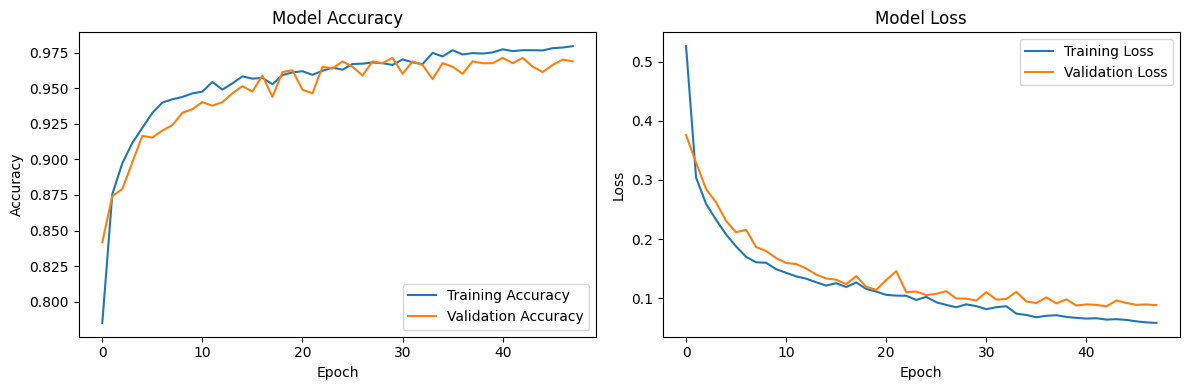

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Quantise the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('/content/drive/MyDrive/TinyML_models/keyword_spotting_quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

Saved artifact at '/tmp/tmp1jnjde08'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 49, 10, 1), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140303171196128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303296796928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160865392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160866800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160941152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160942736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160936752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303160945200: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Compare the models
# Get the size of the original model
original_model_size = os.path.getsize('/content/drive/MyDrive/TinyML_models/keyword_spotting_model.tflite')
print(f"Original TFLite Model Size: {original_model_size / 1024:.2f} KB")

# Get the size of the quantized model
quantized_model_size = os.path.getsize('/content/drive/MyDrive/TinyML_models/keyword_spotting_quantized_model.tflite')
print(f"Quantized TFLite Model Size: {quantized_model_size / 1024:.2f} KB")

Original TFLite Model Size: 10.43 KB
Quantized TFLite Model Size: 7.13 KB


In [ ]:
# Load the entire model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/TinyML_models/keyword_spotting_model')

# Or, if you saved only weights
model.load_weights('/content/drive/MyDrive/TinyML_models/keyword_spotting_weights.h5')